In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from shufflenet_model_v2 import ShuffleNetV2
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, utils,datasets
from PIL import Image
import pandas as pd
import numpy as np

#过滤警告信息
import warnings
warnings.filterwarnings("ignore")

data_transform = transforms.Compose([
 transforms.Resize(384), # 缩放图片(Image)，保持长宽比不变，最短边为32像素
 transforms.CenterCrop(384), # 从图片中间切出32*32的图片2
 transforms.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
 transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 标准化至[-1, 1]，规定均值和标准差
])
test_dataset = datasets.ImageFolder(root=r"C:\Users\huazilong\Desktop\python_code2\Contrast Experiment\test data",
           transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True) 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))
batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
val_num = len(test_dataset)
print("{} images for validation.".format(val_num))


using cuda:0 device.
Using 8 dataloader workers every process
500 images for validation.


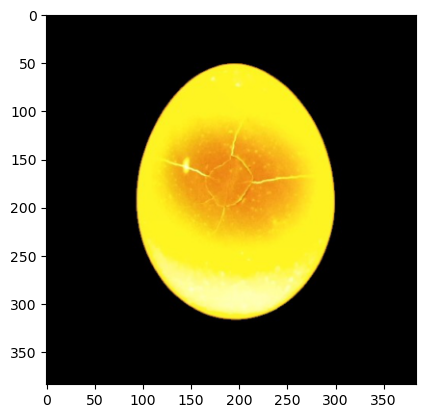

In [3]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# 显示图像
def imshow(img):
 img = img / 2 + 0.5  # unnormalize
 npimg = img.numpy()
 plt.imshow(np.transpose(npimg, (1, 2, 0)))
 plt.show()
# 随机获取部分训练数据
dataiter = iter(test_loader)#此处填写加载的数据集
images, labels = dataiter.__next__()
imshow(torchvision.utils.make_grid(images))
# 打印标签
#print(' '.join('%s' % ["好蛋" if labels[j].item()==1 else "破蛋" for j in range(4)]))

In [4]:
# create model
net = ShuffleNetV2(num_classes=2)
net.to(device)
from torchinfo import summary
summary(net,(1,3,480,480))

Layer (type:depth-idx)                             Output Shape              Param #
ShuffleNetV2                                       [1, 2]                    --
├─Sequential: 1-1                                  [1, 24, 240, 240]         --
│    └─Conv2d: 2-1                                 [1, 24, 240, 240]         648
│    └─BatchNorm2d: 2-2                            [1, 24, 240, 240]         48
│    └─ReLU: 2-3                                   [1, 24, 240, 240]         --
├─MaxPool2d: 1-2                                   [1, 24, 120, 120]         --
├─Sequential: 1-3                                  [1, 464, 15, 15]          --
│    └─InvertedResidual: 2-4                       [1, 116, 60, 60]          --
│    │    └─Sequential: 3-1                        [1, 58, 60, 60]           2,420
│    │    └─Sequential: 3-2                        [1, 58, 60, 60]           7,158
│    └─InvertedResidual: 2-5                       [1, 116, 60, 60]          --
│    │    └─Sequential: 3-3 

In [5]:

# load pretrain weights
# download url: https://download.pytorch.org/models/mobilenet_v2-b0353104.pth
model_weight_path = "./ShuffleNetV2_UCA.pth"
assert os.path.exists(model_weight_path), "file {} dose not exist.".format(model_weight_path)
pre_weights = torch.load(model_weight_path, map_location=device)
# # # # # delete classifier weights
pre_dict = {k: v for k, v in pre_weights.items() if net.state_dict()[k].numel() == v.numel()}
missing_keys, unexpected_keys = net.load_state_dict(pre_dict, strict=False)

# validate
net.eval()
acc = 0.0  # accumulate accurate number / epoch
success = 0
zhaohui = 0
teyi = 0
with torch.no_grad():
    val_bar = tqdm(test_loader)
    for val_data in val_bar:
        val_images, test_labels = val_data
        outputs = net(val_images.to(device))
        #loss = loss_function(outputs, test_labels.to(device))
        predict_y = torch.max(outputs, dim=1)[1]
        success = torch.eq(predict_y, test_labels.to(device)).sum().item()
        acc += success
        if success == 0:
            if test_labels == 0 :
                zhaohui += 1
            else :
                teyi +=1
            #print(predict_y,test_labels)
            #imshow(torchvision.utils.make_grid(val_images))
        val_bar.desc = "valid epoch[{}/{}]".format(1,1)
val_accurate = acc / val_num
print('[epoch %d]  val_accuracy: %.3f' %(1, val_accurate))
print( zhaohui ,teyi)

valid epoch[1/1]: 100%|██████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.26it/s]

[epoch 1]  val_accuracy: 0.962
11 8
